## 改变工作目录

In [2]:
%cd ../src
!ls

/Users/flea/Documents/kaggle/credit_risk/src
cmd.bat     models      summary.log summary.py  train.py


## 导入模块

In [4]:
import os
import gc
import os.path as op
import numpy as np
import feather
import pandas as pd
import fire
import time
import models
# import ..src.models as models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from contextlib import contextmanager
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:

def cache_read(csv_file, cache_suffix=".feather", **kwargs):
	"""
	用pandas读取csv文件，查看是否具有默认的缓存文件，
	如果没有缓存文件，那么按照原始文件进行读取
	"""
	cache_file = csv_file + cache_suffix
	if op.exists(cache_file):
		data = feather.read_dataframe(cache_file)
	else:
		data = pd.read_csv(csv_file, **kwargs)
		feather.write_dataframe(data, cache_file)
	return data




def load_useless_feat(filepath):
    """
    加载后续通过模型筛选出的无用特征
    """
    unused_feat = set()
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line == "" or line.startswith("#"):
                continue
            unused_feat.add(line)
    return unused_feat


def add_columns_tag(df, prefix, keep=['SK_ID_CURR']):

    cols = df.columns.tolist()
    cols = [f_ if f_ in keep else prefix + f_ for f_ in cols]
    df.columns = cols
    return df


@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print('[{}] done in {:.2f} s'.format(name, time.time() - t0))


def add_df_column(df, grp, select, fun=None, new_column=None, 
    new_dtype='uint16', reverse_order=False):
    """
    df, a dataframe object,
    grp, a list
    select, a column name from df
    """
    if fun is None:
        fun = 'count'

    if new_column is None:
        new_column = fun + '_' + '_'.join(grp + [select])

    with timer("Counting {}".format(new_column)):
        if fun == 'cumcount':
            if reverse_order:
                df[new_column] = df[grp + [select]].iloc[::-1, :].groupby(grp)[select].agg(fun).astype(new_dtype) 
            else:
                df[new_column] = df[grp + [select]].groupby(grp)[select].agg(fun).astype(new_dtype) 
        else: 
            df = df.merge(
                df[grp + [select]].groupby(grp)[select].agg(fun).astype(new_dtype).reset_index(). \
                    rename(columns={select: new_column}), how='left')
    return df


def get_group_stat(df, grp, select, fun=None,
                    new_column=None, new_dtype='uint16'):

    if fun is None:
        fun = 'count'
        
    if new_column is None:
        if not isinstance(fun, str):
            fun_name = fun.__name__
        else:
            fun_name = fun
        new_column = fun_name + '_' + '_'.join(grp + [select])

    # not support cumcout
    with timer("Stating {}".format(new_column)):
        stat_df = df[grp + [select]].groupby(grp)[select].agg(fun).astype(new_dtype).\
            reset_index().rename(columns={select: new_column})
        return stat_df


## 读取训练和测试数据集

In [6]:
	# data directory
	cur_dir = '.' # op.dirname(__file__)
	data_dir = op.join(cur_dir, '../data')

	# read data
	print("Processing reading raw data ...")
	train_file = op.join(data_dir, 'application_train.csv.zip')
	train = cache_read(train_file)
	test_file = op.join(data_dir, 'application_test.csv.zip')
	test = cache_read(test_file)
test.head()

Processing reading raw data ...


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## 读取信访局数据

In [7]:
	# bu tag
	bureau_file = op.join(data_dir, 'bureau.csv.zip')
	bureau = cache_read(bureau_file)

	# bub tag
	bureau_balance_file = op.join(data_dir, 'bureau_balance.csv.zip')
	bureau_balance = cache_read(bureau_balance_file)

In [13]:
# bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5715448]

# df = bureau_balance.groupby(['SK_ID_BUREAU'])['MONTHS_BALANCE'].count().sort_values()
# df
# bureau_balance[bureau_balance['SK_ID_BUREAU'] == 6052856]

# 信用局中对每次记录的历史，包括贷款记录等，我们可以统计每笔贷款的月长以及状态的数量
df1 = bureau_balance.groupby(['SK_ID_BUREAU'])['MONTHS_BALANCE'].count().sort_values().reset_index()
df2 = bureau_balance.groupby(['SK_ID_BUREAU', 'STATUS'])['STATUS'].count()
df2 = df2.unstack('STATUS').fillna(0).astype('uint16')
del df2.columns.name
df2 = df2.reset_index()
df = pd.merge(df1, df2, how='left', on=['SK_ID_BUREAU'])
df.sample(5)

,SK_ID_BUREAU,MONTHS_BALANCE,0,1,2,3,4,5,C,X
184253,5336862,12,0,0,0,0,0,0,0,12
103280,6718982,7,5,0,0,0,0,0,2,0
465012,6664695,31,5,0,0,0,0,0,26,0
147829,5315013,10,2,0,0,0,0,0,8,0
578421,5875913,43,5,0,0,0,0,0,38,0


In [9]:
bureau2 = pd.merge(bureau, df, how='left', on=['SK_ID_BUREAU'])
del df1, df2, df
bureau2.isnull().sum() / bureau2.shape[0]

SK_ID_CURR                0.000000
SK_ID_BUREAU              0.000000
CREDIT_ACTIVE             0.000000
CREDIT_CURRENCY           0.000000
DAYS_CREDIT               0.000000
CREDIT_DAY_OVERDUE        0.000000
DAYS_CREDIT_ENDDATE       0.061496
DAYS_ENDDATE_FACT         0.369170
AMT_CREDIT_MAX_OVERDUE    0.655133
CNT_CREDIT_PROLONG        0.000000
AMT_CREDIT_SUM            0.000008
AMT_CREDIT_SUM_DEBT       0.150119
AMT_CREDIT_SUM_LIMIT      0.344774
AMT_CREDIT_SUM_OVERDUE    0.000000
CREDIT_TYPE               0.000000
DAYS_CREDIT_UPDATE        0.000000
AMT_ANNUITY               0.714735
MONTHS_BALANCE            0.548857
0                         0.548857
1                         0.548857
2                         0.548857
3                         0.548857
4                         0.548857
5                         0.548857
C                         0.548857
X                         0.548857
dtype: float64

In [34]:
print(bureau2.shape[0] == bureau2[['SK_ID_CURR', 'SK_ID_BUREAU']].drop_duplicates().shape[0])
bureau2.head()

True


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,AMT_ANNUITY,MONTHS_BALANCE,0,1,2,3,4,5,C,X
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# df1 = get_group_stat(bureau, ['SK_ID_CURR'], 'SK_ID_BUREAU', fun='nunique')
df = get_group_stat(bureau2, ['SK_ID_CURR', 'CREDIT_ACTIVE'], 'SK_ID_BUREAU', 'nunique')
# df.CREDIT_ACTIVE.value_counts()      # closed, active, sold, bad debt.
'''
Closed      267925
Active      251815
Sold          6021
Bad debt        21
Name: CREDIT_ACTIVE, dtype: int64
'''
df = df.pivot_table(index=['SK_ID_CURR'], columns=['CREDIT_ACTIVE'], fill_value=0)
df.head()

[Stating nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU] done in 0.73 s


nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU                  \
CREDIT_ACTIVE                                        Active Bad debt Closed   
SK_ID_CURR                                                                    
100001                                                    3        0      4   
100002                                                    2        0      6   
100003                                                    1        0      3   
100004                                                    0        0      2   
100005                                                    2        0      1   

                    
CREDIT_ACTIVE Sold  
SK_ID_CURR          
100001           0  
100002           0  
100003           0  
100004           0  
100005           0

In [53]:
cols = []
for idx0, idx1 in zip(df.columns.labels[0], df.columns.labels[1]):
    # print(idx0, idx1)
    col = [df.columns.levels[0][idx0], df.columns.levels[1][idx1].replace(' ', '_')]
    cols.append('_'.join(col))

df.columns = cols
df.head()

,nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU_Active,nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU_Bad_debt,nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU_Closed,nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU_Sold
SK_ID_CURR,,,,
100001,3,0,4,0
100002,2,0,6,0
100003,1,0,3,0
100004,0,0,2,0
100005,2,0,1,0


In [58]:
def pivot_stat_single(df, index, column, fill_value=None):
    """
    将两列的统计量reshape成一列并将列名更改
    """
    df = df.pivot_table(index=index, columns=column, fill_value=fill_value)
    cols = []
    for idx0, idx1 in zip(df.columns.labels[0], df.columns.labels[1]):
        col = [df.columns.levels[0][idx0], df.columns.levels[1][idx1].replace(' ', '_')]
        cols.append('_'.join(col))

    df.columns = cols
    df = df.reset_index()
    return df

df = get_group_stat(bureau2, ['SK_ID_CURR', 'CREDIT_ACTIVE'], 'SK_ID_BUREAU', 'nunique')
df = pivot_stat_single(df, 'SK_ID_CURR', 'CREDIT_ACTIVE', fill_value=0)
df.head()

[Stating nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU] done in 0.71 s


,SK_ID_CURR,nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU_Active,nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU_Bad_debt,nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU_Closed,nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU_Sold
0,100001,3,0,4,0
1,100002,2,0,6,0
2,100003,1,0,3,0
3,100004,0,0,2,0
4,100005,2,0,1,0


In [63]:
df_tmp = get_group_stat(bureau2, ['SK_ID_CURR'], 'CREDIT_CURRENCY', fun='nunique')
# df_tmp['nunique_SK_ID_CURR_CREDIT_CURRENCY'].value_counts()
'''
1    304739
2      1045
3        27
Name: nunique_SK_ID_CURR_CREDIT_CURRENCY, dtype: int64
'''
df_tmp.head()

[Stating nunique_SK_ID_CURR_CREDIT_CURRENCY] done in 1.35 s


,SK_ID_CURR,nunique_SK_ID_CURR_CREDIT_CURRENCY
0,100001,1
1,100002,1
2,100003,1
3,100004,1
4,100005,1


In [67]:
    # 借贷多少次
    df = get_group_stat(bureau, ['SK_ID_CURR'], 'SK_ID_BUREAU', 
        fun='nunique', new_dtype='uint16')
    # 借贷状态
    df_tmp = get_group_stat(bureau, ['SK_ID_CURR', 'CREDIT_ACTIVE'], 
        'SK_ID_BUREAU', 'nunique')
    df_tmp = pivot_stat_single(df_tmp, 'SK_ID_CURR', 'CREDIT_ACTIVE', fill_value=0)
    df = df.merge(df_tmp, how='left', on=['SK_ID_CURR'])
    # 借贷币种
    df_tmp = get_group_stat(bureau, ['SK_ID_CURR'], 'CREDIT_CURRENCY', fun='nunique')
    df = df.merge(df_tmp, how='left', on=['SK_ID_CURR'])

    df_tmp = get_group_stat(bureau, ['SK_ID_CURR', 'CREDIT_CURRENCY'], 'SK_ID_BUREAU', fun='nunique')
    df_tmp = pivot_stat_single(df_tmp, 'SK_ID_CURR', 'CREDIT_CURRENCY', fill_value=0)
    df = df.merge(df_tmp, how='left', on=['SK_ID_CURR'])
    # 平均借贷时间，除了closed的
    df_tmp = get_group_stat(bureau[bureau['CREDIT_ACTIVE'] != 'Closed'],
        ['SK_ID_CURR'], 'DAYS_CREDIT', fun='mean', new_dtype='float32')
    df = df.merge(df_tmp, how='left', on=['SK_ID_CURR']).fillna(0)
    df_tmp = get_group_stat(bureau[bureau['CREDIT_ACTIVE'] != 'Closed'],
        ['SK_ID_CURR'], 'DAYS_CREDIT', fun='std', new_dtype='float32')
    df = df.merge(df_tmp, how='left', on=['SK_ID_CURR']).fillna(0)
    df.head()

[Stating nunique_SK_ID_CURR_SK_ID_BUREAU] done in 0.37 s
[Stating nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU] done in 0.70 s
[Stating nunique_SK_ID_CURR_CREDIT_CURRENCY] done in 1.30 s
[Stating nunique_SK_ID_CURR_CREDIT_CURRENCY_SK_ID_BUREAU] done in 0.62 s
[Stating mean_SK_ID_CURR_DAYS_CREDIT] done in 0.08 s
[Stating std_SK_ID_CURR_DAYS_CREDIT] done in 0.11 s


,SK_ID_CURR,nunique_SK_ID_CURR_SK_ID_BUREAU,nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU_Active,nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU_Bad_debt,nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU_Closed,nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU_Sold,nunique_SK_ID_CURR_CREDIT_CURRENCY,nunique_SK_ID_CURR_CREDIT_CURRENCY_SK_ID_BUREAU_currency_1,nunique_SK_ID_CURR_CREDIT_CURRENCY_SK_ID_BUREAU_currency_2,nunique_SK_ID_CURR_CREDIT_CURRENCY_SK_ID_BUREAU_currency_3,nunique_SK_ID_CURR_CREDIT_CURRENCY_SK_ID_BUREAU_currency_4,mean_SK_ID_CURR_DAYS_CREDIT,std_SK_ID_CURR_DAYS_CREDIT
0,100001,7,3,0,4,0,1,7,0,0,0,-309.333344,255.167267
1,100002,8,2,0,6,0,1,8,0,0,0,-572.500000,663.973267
2,100003,4,1,0,3,0,1,4,0,0,0,-606.000000,0.000000
3,100004,2,0,0,2,0,1,2,0,0,0,0.000000,0.000000
4,100005,3,2,0,1,0,1,3,0,0,0,-99.500000,53.033009


In [74]:
df_tmp = get_group_stat(bureau, ['SK_ID_CURR'], 'CREDIT_DAY_OVERDUE', fun='max')
df_tmp.sample(5)

[Stating max_SK_ID_CURR_CREDIT_DAY_OVERDUE] done in 0.20 s


,SK_ID_CURR,max_SK_ID_CURR_CREDIT_DAY_OVERDUE
170271,298193,0
173480,301929,0
216746,352481,0
297981,447112,0
23648,127506,0


In [77]:
df_tmp = get_group_stat(bureau2[['SK_ID_CURR', 'DAYS_CREDIT_ENDDATE']].dropna(),
        ['SK_ID_CURR'], 'DAYS_CREDIT_ENDDATE', fun='mean', new_dtype='float32')
df_tmp.head()

[Stating mean_SK_ID_CURR_DAYS_CREDIT_ENDDATE] done in 0.15 s


,SK_ID_CURR,mean_SK_ID_CURR_DAYS_CREDIT_ENDDATE
0,100001,82.428574
1,100002,-349.000000
2,100003,-544.500000
3,100004,-488.500000
4,100005,439.333344


In [85]:
c = 'AMT_CREDIT_MAX_OVERDUE'
df_tmp = get_group_stat(bureau[['SK_ID_CURR', c]].dropna(),
    ['SK_ID_CURR'], c, fun='max', new_dtype='float32')
df_tmp.iloc[:, 1] = df_tmp.iloc[:, 1].apply(np.log1p)
df_tmp.head()

[Stating max_SK_ID_CURR_AMT_CREDIT_MAX_OVERDUE] done in 0.08 s


,SK_ID_CURR,max_SK_ID_CURR_AMT_CREDIT_MAX_OVERDUE
0,100002,8.526083
1,100003,0.000000
2,100004,0.000000
3,100005,0.000000
4,100007,0.000000


In [88]:
c = 'CREDIT_TYPE'
df_tmp = get_group_stat(bureau, ['SK_ID_CURR', c], 'SK_ID_BUREAU', fun='nunique')
df_tmp = pivot_stat_single(df_tmp, 'SK_ID_CURR', c, fill_value=0)
df_tmp.head()

[Stating nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU] done in 0.79 s


,SK_ID_CURR,nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Another_type_of_loan,nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Car_loan,nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Cash_loan_(non-earmarked),nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Consumer_credit,nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Credit_card,nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Interbank_credit,nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Loan_for_business_development,nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Loan_for_purchase_of_shares_(margin_lending),nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Loan_for_the_purchase_of_equipment,nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Loan_for_working_capital_replenishment,nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Microloan,nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Mobile_operator_loan,nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Mortgage,nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Real_estate_loan,nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Unknown_type_of_loan
0,100001,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0
1,100002,0,0,0,4,4,0,0,0,0,0,0,0,0,0,0
2,100003,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0
3,100004,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
4,100005,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0


In [91]:
bureau2.iloc[:, -9:].sample(5)

,MONTHS_BALANCE,0,1,2,3,4,5,C,X
620446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19663,40.0,6.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0
822796,35.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
1070998,28.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,15.0


## Credit card balance history

In [93]:
	# ccb tag
	credit_card_balance_file = op.join(data_dir, 'credit_card_balance.csv.zip')
	credit_card_balance = cache_read(credit_card_balance_file)

In [102]:
    c = 'SK_ID_PREV'
    df = get_group_stat(credit_card_balance, ['SK_ID_CURR'], c, fun='nunique')
    df.head()

[Stating nunique_SK_ID_CURR_SK_ID_PREV] done in 1.46 s


,SK_ID_CURR,nunique_SK_ID_CURR_SK_ID_PREV
0,100006,1
1,100011,1
2,100013,1
3,100021,1
4,100023,1


In [105]:
df['nunique_SK_ID_CURR_SK_ID_PREV'].value_counts()

1    102818
2       732
3         7
4         1
Name: nunique_SK_ID_CURR_SK_ID_PREV, dtype: int64

In [107]:
credit_card_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [101]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [98]:
credit_card_balance.info()
credit_card_balance.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int64
SK_ID_CURR                    int64
MONTHS_BALANCE                int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL       int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT          int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS          object
SK_DPD                        int64
SK_DPD_DEF                    int64
dtypes: float64(15), int64(7

SK_ID_PREV                         0
SK_ID_CURR                         0
MONTHS_BALANCE                     0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_CURRENT               0
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
AMT_INST_MIN_REGULARITY       305236
AMT_PAYMENT_CURRENT           767988
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECEIVABLE_PRINCIPAL           0
AMT_RECIVABLE                      0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_CURRENT               0
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
NAME_CONTRACT_STATUS               0
SK_DPD                             0
SK_DPD_DEF                         0
dtype: int64

In [100]:
credit_card_balance['NAME_CONTRACT_STATUS'].value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

In [115]:
c = 'NAME_CONTRACT_STATUS'
df_tmp = get_group_stat(credit_card_balance, ['SK_ID_CURR', c], 'SK_ID_PREV', fun='count')
# df_tmp = get_group_stat(df_tmp, ['SK_ID_CURR'], df_tmp.columns.tolist()[-1], 'max')
df_tmp = pivot_stat_single(df_tmp, 'SK_ID_CURR', 'NAME_CONTRACT_STATUS', fill_value=0)
df_tmp.head()

[Stating count_SK_ID_CURR_NAME_CONTRACT_STATUS_SK_ID_PREV] done in 0.84 s


,SK_ID_CURR,count_SK_ID_CURR_NAME_CONTRACT_STATUS_SK_ID_PREV_Active,count_SK_ID_CURR_NAME_CONTRACT_STATUS_SK_ID_PREV_Approved,count_SK_ID_CURR_NAME_CONTRACT_STATUS_SK_ID_PREV_Completed,count_SK_ID_CURR_NAME_CONTRACT_STATUS_SK_ID_PREV_Demand,count_SK_ID_CURR_NAME_CONTRACT_STATUS_SK_ID_PREV_Refused,count_SK_ID_CURR_NAME_CONTRACT_STATUS_SK_ID_PREV_Sent_proposal,count_SK_ID_CURR_NAME_CONTRACT_STATUS_SK_ID_PREV_Signed
0,100006,6,0,0,0,0,0,0
1,100011,74,0,0,0,0,0,0
2,100013,96,0,0,0,0,0,0
3,100021,7,0,10,0,0,0,0
4,100023,8,0,0,0,0,0,0


# Installment payment info

In [7]:
	# itp tag
	installments_payments_file = op.join(data_dir, 'installments_payments.csv.zip')
	installments_payments = cache_read(installments_payments_file)

In [8]:
    c = 'SK_ID_PREV'
    df = get_group_stat(installments_payments, ['SK_ID_CURR'], c, fun='nunique')
    df_tmp = get_group_stat(installments_payments, ['SK_ID_CURR'], c, fun='count')
    df = df.merge(df_tmp, how='left', on=['SK_ID_CURR'])
    df.head()

[Stating nunique_SK_ID_CURR_SK_ID_PREV] done in 4.65 s
[Stating count_SK_ID_CURR_SK_ID_PREV] done in 0.56 s


,SK_ID_CURR,nunique_SK_ID_CURR_SK_ID_PREV,count_SK_ID_CURR_SK_ID_PREV
0,100001,2,7
1,100002,1,19
2,100003,3,25
3,100004,1,3
4,100005,1,9


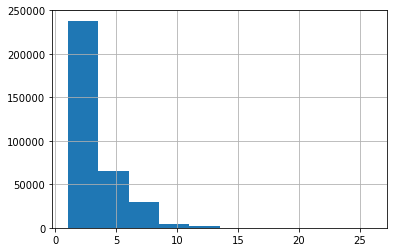

In [9]:
df.nunique_SK_ID_CURR_SK_ID_PREV.hist()

In [124]:
installments_payments.sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER']).head(20)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
1478621,1369693,100001,1.0,1,-1709.0,-1715.0,3951.000,3951.000
2568722,1369693,100001,1.0,2,-1679.0,-1715.0,3951.000,3951.000
3458712,1369693,100001,1.0,3,-1649.0,-1660.0,3951.000,3951.000
2624024,1369693,100001,2.0,4,-1619.0,-1628.0,17397.900,17397.900
1761012,1851984,100001,1.0,2,-2916.0,-2916.0,3982.050,3982.050
3774071,1851984,100001,1.0,3,-2886.0,-2875.0,3982.050,3982.050
3435373,1851984,100001,1.0,4,-2856.0,-2856.0,3980.925,3980.925
2144879,1038818,100002,1.0,1,-565.0,-587.0,9251.775,9251.775
2163032,1038818,100002,1.0,2,-535.0,-562.0,9251.775,9251.775
1675768,1038818,100002,1.0,3,-505.0,-529.0,9251.775,9251.775


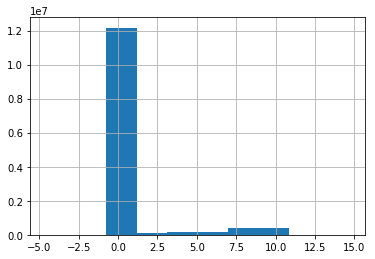

In [11]:
(installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT'])

In [118]:
installments_payments.info()
installments_payments.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int64
SK_ID_CURR                int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER     int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

In [12]:
	# pcb tag
	pos_cash_balance_file = op.join(data_dir, 'POS_CASH_balance.csv.zip')
	pos_cash_balance = cache_read(pos_cash_balance_file)

In [13]:
pos_cash_balance['NAME_CONTRACT_STATUS'].value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [126]:
pos_cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [127]:
pos_cash_balance.info()
pos_cash_balance.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
SK_ID_PREV               int64
SK_ID_CURR               int64
MONTHS_BALANCE           int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS     object
SK_DPD                   int64
SK_DPD_DEF               int64
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

# Previous application records

In [133]:
# pa tag
previous_application_file = op.join(data_dir, 'previous_application.csv.zip')
previous_app = cache_read(previous_application_file)
previous_app = previous_app.sort_values(['SK_ID_CURR', 'SK_ID_PREV'])    

In [132]:
df = get_group_stat(previous_app, ['SK_ID_CURR'], 'SK_ID_PREV', 'count')
df.head()

[Stating count_SK_ID_CURR_SK_ID_PREV] done in 0.21 s


,SK_ID_CURR,count_SK_ID_CURR_SK_ID_PREV
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


In [135]:
previous_app[['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START']].head()

,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START
201668,FRIDAY,13
892077,SATURDAY,9
575941,FRIDAY,12
1223745,SATURDAY,15
1021650,SUNDAY,17


In [161]:
    # previous_app.groupby(['SK_ID_CURR'])['NAME_CONTRACT_TYPE'].apply(lambda x: ','.join(sorted(list(set(x))))).head()
    def concate_str(x):
        x = list(set(x))
        x = sorted(x)
        return ','.join(x)
        
    df_tmp = get_group_stat(previous_app, ['SK_ID_CURR'], 'NAME_CONTRACT_TYPE', concate_str, new_dtype='object')
    df_tmp.head()

[Stating concate_str_SK_ID_CURR_NAME_CONTRACT_TYPE] done in 5.90 s


,SK_ID_CURR,concate_str_SK_ID_CURR_NAME_CONTRACT_TYPE
0,100001,Consumer loans
1,100002,Consumer loans
2,100003,"Cash loans,Consumer loans"
3,100004,Consumer loans
4,100005,"Cash loans,Consumer loans"


In [168]:
[f for f in previous_app.columns.tolist() if previous_app[f].dtype != 'object']

['SK_ID_PREV',
 'SK_ID_CURR',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL']

In [170]:
obj_cols = [f for f in previous_app.columns.tolist() if previous_app[f].dtype == 'object']

In [177]:
#previous_app[['SK_ID_PREV',
# 'SK_ID_CURR'] + obj_cols].head()
for c in obj_cols:
    print(previous_app[c].value_counts())
    print('---' * 20)

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE, dtype: int64
------------------------------------------------------------
TUESDAY      255118
WEDNESDAY    255010
MONDAY       253557
FRIDAY       252048
THURSDAY     249099
SATURDAY     240631
SUNDAY       164751
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64
------------------------------------------------------------
Y    1661739
N       8475
Name: FLAG_LAST_APPL_PER_CONTRACT, dtype: int64
------------------------------------------------------------
XAP                                 922661
XNA                                 677918
Repairs                              23765
Other                                15608
Urgent needs                          8412
Buying a used car                     2888
Building a house or an annex          2693
Everyday expenses                     2416
Medicine                              2174
Payments on other loans   

In [178]:
previous_app[obj_cols].isnull().sum()

NAME_CONTRACT_TYPE                  0
WEEKDAY_APPR_PROCESS_START          0
FLAG_LAST_APPL_PER_CONTRACT         0
NAME_CASH_LOAN_PURPOSE              0
NAME_CONTRACT_STATUS                0
NAME_PAYMENT_TYPE                   0
CODE_REJECT_REASON                  0
NAME_TYPE_SUITE                820405
NAME_CLIENT_TYPE                    0
NAME_GOODS_CATEGORY                 0
NAME_PORTFOLIO                      0
NAME_PRODUCT_TYPE                   0
CHANNEL_TYPE                        0
NAME_SELLER_INDUSTRY                0
NAME_YIELD_GROUP                    0
PRODUCT_COMBINATION               346
dtype: int64

In [130]:
previous_app.info()
previous_app.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
SK_ID_PREV                     1670214 non-null int64
SK_ID_CURR                     1670214 non-null int64
NAME_CONTRACT_TYPE             1670214 non-null object
AMT_ANNUITY                    1297979 non-null float64
AMT_APPLICATION                1670214 non-null float64
AMT_CREDIT                     1670213 non-null float64
AMT_DOWN_PAYMENT               774370 non-null float64
AMT_GOODS_PRICE                1284699 non-null float64
WEEKDAY_APPR_PROCESS_START     1670214 non-null object
HOUR_APPR_PROCESS_START        1670214 non-null int64
FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null object
NFLAG_LAST_APPL_IN_DAY         1670214 non-null int64
RATE_DOWN_PAYMENT              774370 non-null float64
RATE_INTEREST_PRIMARY          5951 non-null float64
RATE_INTEREST_PRIVILEGED       5951 non-null float64
NAME_CASH_LOAN_PURPOSE         1670214 non-null object
NAME_CONTRA

SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE             

In [ ]:
# credit_card_balance.isnull().sum() / credit_card_balance.shape[0]
credit_card_balance = credit_card_balance.sort_values(['SK_ID_CURR','SK_ID_PREV', 'MONTHS_BALANCE'])
credit_card_balance.head()

In [ ]:
s1 = credit_card_balance.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
s1.sort_values().tail()

In [ ]:
# credit_card_balance[credit_card_balance['SK_ID_CURR'] == 355767]
(s1 > 1).sum() / len(s1)

In [ ]:
credit_card_balance.tail()

In [ ]:
installments_payments = installments_payments.sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
installments_payments.head()

In [ ]:
pos_cash_balance = pos_cash_balance.sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'])
pos_cash_balance.head()

In [ ]:
pos_cash_balance[(pos_cash_balance['CNT_INSTALMENT_FUTURE'] == 0) & (pos_cash_balance['NAME_CONTRACT_STATUS'] != 'Completed')].tail()

In [ ]:
pos_cash_balance.isnull().sum() / pos_cash_balance.shape[0], pos_cash_balance.shape[0]

In [ ]:
previous_app = previous_app.sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
previous_app.head()

In [5]:
n_folds = 3
opt = {'n_estimator': 200, 'early_stopping_round': 10}
clf = models.GBMClassifier(opt)

In [6]:
# 训练和测试集是独立的，且每个都是无重复的ID。
print(train['SK_ID_CURR'].nunique() == train.shape[0])
print(test['SK_ID_CURR'].nunique() == test.shape[0])
print(len(set(train['SK_ID_CURR'].tolist()) & set(test['SK_ID_CURR'].tolist())))

True
True
0


In [7]:
	y = train['TARGET']
	train.drop(['TARGET'], axis=1, inplace=True)
	train_size = train.shape[0]
	train = pd.concat([train, test])
	del test

In [8]:
train = train.fillna(-99)       # must before make category

# make category
for _f in train.columns.tolist():
    
    if train[_f].dtype == 'object':
        train[_f] = train[_f].astype('category')

In [9]:
	

	# split the data into train and test
	test = train.iloc[train_size:, :]
	train = train.iloc[:train_size, :]

	feat_selected = train.columns.tolist()[1:]

	# do stacking.
	cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=521)
	train_pred = np.zeros(train.shape[0])
	test_pred = np.zeros((test.shape[0], n_folds))
	feat_imp = pd.DataFrame(np.zeros((len(feat_selected), n_folds)))
	feat_imp['features'] = feat_selected

In [14]:
	for k, (trn_idx, val_idx) in enumerate(cv.split(train, y)):
		trn_x, trn_y = train[feat_selected].iloc[trn_idx], y.iloc[trn_idx]
		val_x, val_y = train[feat_selected].iloc[val_idx], y.iloc[val_idx]

		clf.fit(train_set=(trn_x, trn_y), valid_set=(val_x, val_y))

		train_pred[val_idx] = clf.predict_proba(val_x)
		test_pred[:, k] = clf.predict_proba(test[feat_selected])

		stat = roc_auc_score(val_y, train_pred[val_idx])
		print("K={}, AUC: {:.3f}".format(k, stat))

		# collect importance info
		feat_imp.iloc[:, k] = clf.get_feat_imp()

[1]	valid's auc: 0.67321
Training until validation scores don't improve for 10 rounds.
[2]	valid's auc: 0.708593
[3]	valid's auc: 0.712618
[4]	valid's auc: 0.722042
[5]	valid's auc: 0.720779
[6]	valid's auc: 0.721966
[7]	valid's auc: 0.724119
[8]	valid's auc: 0.724251
[9]	valid's auc: 0.727583
[10]	valid's auc: 0.727349
[11]	valid's auc: 0.729123
[12]	valid's auc: 0.728262
[13]	valid's auc: 0.727577
[14]	valid's auc: 0.727471
[15]	valid's auc: 0.728071
[16]	valid's auc: 0.729134
[17]	valid's auc: 0.731204
[18]	valid's auc: 0.730675
[19]	valid's auc: 0.730639
[20]	valid's auc: 0.73122
[21]	valid's auc: 0.730845
[22]	valid's auc: 0.731629
[23]	valid's auc: 0.731436
[24]	valid's auc: 0.731428
[25]	valid's auc: 0.731556
[26]	valid's auc: 0.732376
[27]	valid's auc: 0.732361
[28]	valid's auc: 0.732281
[29]	valid's auc: 0.73355
[30]	valid's auc: 0.733272
[31]	valid's auc: 0.733086
[32]	valid's auc: 0.732935
[33]	valid's auc: 0.733778
[34]	valid's auc: 0.733711
[35]	valid's auc: 0.734484
[36]	

[93]	valid's auc: 0.75018
[94]	valid's auc: 0.750441
[95]	valid's auc: 0.750676
[96]	valid's auc: 0.750731
[97]	valid's auc: 0.750908
[98]	valid's auc: 0.750992
[99]	valid's auc: 0.751086
[100]	valid's auc: 0.75115
Did not meet early stopping. Best iteration is:
[100]	valid's auc: 0.75115
K=2, AUC: 0.751


In [17]:
print(train_pred.shape)
print(test_pred.shape)
print(feat_imp.shape)

(307511,)
(48744, 3)
(120, 4)


In [18]:
feat_imp.head()

,0,1,2,features
0,28,25,34,NAME_CONTRACT_TYPE
1,82,82,82,CODE_GENDER
2,24,36,33,FLAG_OWN_CAR
3,3,2,1,FLAG_OWN_REALTY
4,0,1,4,CNT_CHILDREN


In [25]:
feat_imp['imp_mean'] = feat_imp.iloc[:, :n_folds].mean(axis=1)
feat_imp['imp_std'] = feat_imp.iloc[:, :n_folds].std(axis=1)
feat_imp = feat_imp.iloc[:, n_folds:]
feat_imp.head()

,features,imp_mean,imp_std
0,NAME_CONTRACT_TYPE,29.000000,4.582576
1,CODE_GENDER,82.000000,0.000000
2,FLAG_OWN_CAR,31.000000,6.244998
3,FLAG_OWN_REALTY,2.000000,1.000000
4,CNT_CHILDREN,1.666667,2.081666


In [29]:
np.mean(test_pred, axis=1).shape, test_pred.shape

((48744,), (48744, 3))